In [1]:
import os, sys
sys.path.append("../..")

import attr
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.base import State
from filterflow.resampling.standard import SystematicResampler, StratifiedResampler, MultinomialResampler
from filterflow.resampling.base import NoResampling
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform, PartiallyCorrectedRegularizedTransform
from filterflow.resampling.differentiable.optimized import OptimizedPointCloud
from filterflow.resampling.differentiable.optimizer.sgd import SGD
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver
from filterflow.resampling.differentiable.loss.sliced_wasserstein.swd import SlicedWassersteinDistance
from filterflow.resampling.differentiable.loss.regularized import SinkhornLoss
from filterflow.resampling.differentiable.loss.sliced_wasserstein.utils import sqeuclidean, norm_1

This notebook aims to demonstrate the differentiability issue encountered at resampling time. To do this we will compare functionals of the point cloud whilst changing a parameter.

In [4]:
tf.random.set_seed(222)

B = 1
N = 25
D = 1

x = tf.random.normal([B, N, D], 0., 1.)
y = tf.zeros(D)

log_weights = tf.zeros([B, N]) - math.log(N)



In [5]:
def log_likelihood(state, observation, resampler):
    rv = tfp.distributions.MultivariateNormalDiag(tf.zeros(D), tf.ones(D))
    flags = tf.constant([True])
    log_prob = rv.log_prob(observation-state.particles)
    log_weights = log_prob - tf.reduce_logsumexp(log_prob, 1, keepdims=True)
    state = attr.evolve(state, log_weights=log_weights, weights=tf.math.exp(log_weights))
    state = resampler.apply(state, flags)
    log_prob = rv.log_prob(observation-state.particles) + state.log_weights
    return tf.reduce_logsumexp(log_prob)
    

In [6]:
n_data = 150
linspace = np.linspace(-0.5, 0.5, n_data).astype(np.float32)
linspace_dataset = tf.data.Dataset.from_tensor_slices(linspace)

In [7]:
@tf.function
def get_data_no_reset_seed(linspace, resampler, x, y):
    res = tf.TensorArray(dtype=tf.float32, dynamic_size=False, size=n_data)
    grads = tf.TensorArray(dtype=tf.float32, dynamic_size=False, size=n_data)
    i = tf.constant(0, dtype=tf.int64)
    s = tf.constant(0., dtype=tf.float64)
    total_tic = tf.timestamp()
    for i, z_val in linspace_dataset.enumerate():
        tic = tf.timestamp()
        with tf.GradientTape() as tape:
            tape.watch(z_val)
            z = z_val + tf.zeros(D)
            state = State(x + z, log_weights, tf.math.exp(log_weights), tf.constant([0.]), None, None)
            ll = log_likelihood(state, y, resampler)
        ll_grad = tape.gradient(ll, z_val)
        j = tf.cast(i, tf.int32)
        res = res.write(j, ll)

        grads = grads.write(j, ll_grad)
        toc = tf.timestamp()
        s = s + (toc - tic)
        tf.print('Step', i+1, '/', n_data, ', seconds/iter =', s / tf.cast(i+1, tf.float64), end='\r')
    total_toc = tf.timestamp()

    tf.print('Step', i+1, '/', n_data, ', total time (seconds) =', total_toc - total_tic)
    return res.stack(), grads.stack()

# do not decorate this. seed is being set
def get_data(linspace, resampler, x, y, seed):
    res = []
    grads = []
    for z_val in tqdm.tqdm(linspace):
        z_ = tf.constant(z_val)
        tf.random.set_seed(seed)
        with tf.GradientTape() as tape:
            tape.watch(z_)
            z = z_ + tf.zeros(D)
            state = State(x + z, log_weights, tf.math.exp(log_weights), tf.constant([0.]), None, None)
            ll = log_likelihood(state, y, resampler)
        ll_grad = tape.gradient(ll, z)
        res.append(ll.numpy().sum())
        grads.append(ll_grad.numpy().sum())
        
    return res, grads
        

In [8]:
systematic = SystematicResampler()
multinomial = MultinomialResampler()
stratified = StratifiedResampler()
no_resampling = NoResampling()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)
convergence_threshold = tf.constant(1e-4)
max_iter = tf.constant(500)

regularized = RegularisedTransform(epsilon, scaling, max_iter, convergence_threshold)

partially_corrected = PartiallyCorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold)
partially_corrected_no_grad = PartiallyCorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, propagate_correction_gradient=False)

solver = PetkovSolver(n_iter=tf.constant(50))
corrected_no_grad = CorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=False)
corrected = CorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=True)

sinkhorn_loss = SinkhornLoss(epsilon, symmetric=True, scaling=scaling, max_iter=tf.constant(100), convergence_threshold=convergence_threshold)
sinkhorn_optimizer = SGD(sinkhorn_loss, 1., 50, 0.9)
sinkhorn_optimized_cloud = OptimizedPointCloud(sinkhorn_optimizer, regularized)

sliced_loss = SlicedWassersteinDistance(15, sqeuclidean)
sliced_optimizer = SGD(sliced_loss, 1., 50, 0.9)
sliced_optimized_cloud = OptimizedPointCloud(sliced_optimizer, regularized)

In [9]:
no_resampling_data, no_resampling_grad = get_data_no_reset_seed(linspace, no_resampling, x, y)
systematic_data, systematic_grad = get_data(linspace, systematic, x, y, 42)
multinomial_data, multinomial_grad = get_data(linspace, multinomial, x, y, 51)
stratified_data, stratified_grad = get_data(linspace, stratified, x, y, 44)

regularized_data, regularized_grad = get_data_no_reset_seed(linspace, regularized, x, y)
corrected_no_grad_data, corrected_no_grad_grad = get_data_no_reset_seed(linspace, corrected_no_grad, x, y)
partially_corrected_no_grad_data, partially_corrected_no_grad_grad = get_data_no_reset_seed(linspace, partially_corrected_no_grad, x, y)
corrected_data, corrected_grad = get_data_no_reset_seed(linspace, corrected, x, y)
partially_corrected_data, partially_corrected_grad = get_data_no_reset_seed(linspace, partially_corrected, x, y)
sliced_optimized_data, sliced_optimized_grad = get_data_no_reset_seed(linspace, sliced_optimized_cloud, x, y)
sinkhorn_optimized_data, sinkhorn_optimized_grad = get_data_no_reset_seed(linspace, sinkhorn_optimized_cloud, x, y)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Step 150 / 150 , total time (seconds) = 0.287247896194458


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 31.88it/s]


Step 150 / 150 , total time (seconds) = 1.3447029590606689
Step 150 / 150 , total time (seconds) = 2.25952410697937
Step 150 / 150 , total time (seconds) = 1.425839900970459
Step 150 / 150 , total time (seconds) = 3.5542910099029541
Step 150 / 150 , total time (seconds) = 1.4862430095672607
Step 150 / 150 , total time (seconds) = 13.30472207069397
Step 150 / 150 , total time (seconds) = 46.222140073776245


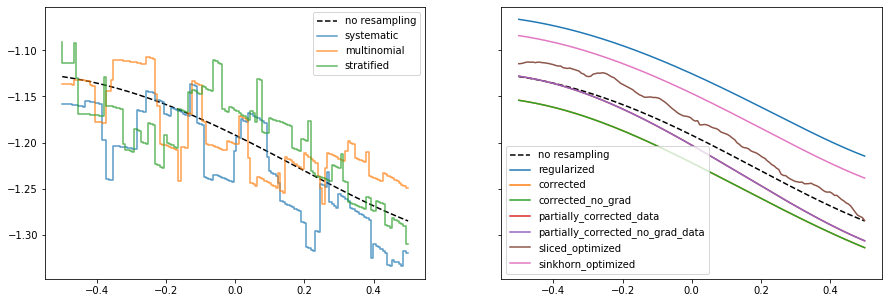

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(linspace, no_resampling_data, label='no resampling', linestyle='--', color='k')
axes[1].plot(linspace, no_resampling_data, label='no resampling', linestyle='--', color='k')
axes[0].step(linspace, systematic_data, label='systematic', alpha=0.75)
axes[0].step(linspace, multinomial_data, label='multinomial', alpha=0.75)
axes[0].step(linspace, stratified_data, label='stratified', alpha=0.75)
axes[1].plot(linspace, regularized_data, label='regularized')
axes[1].plot(linspace, corrected_data, label='corrected')
axes[1].plot(linspace, corrected_no_grad_data, label='corrected_no_grad')
axes[1].plot(linspace, partially_corrected_data, label='partially_corrected_data')
axes[1].plot(linspace, partially_corrected_no_grad_data, label='partially_corrected_no_grad_data')
axes[1].plot(linspace, sliced_optimized_data, label='sliced_optimized')
axes[1].plot(linspace, sinkhorn_optimized_data, label='sinkhorn_optimized')
_ = axes[0].legend(), axes[1].legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration_likelihood.png'))

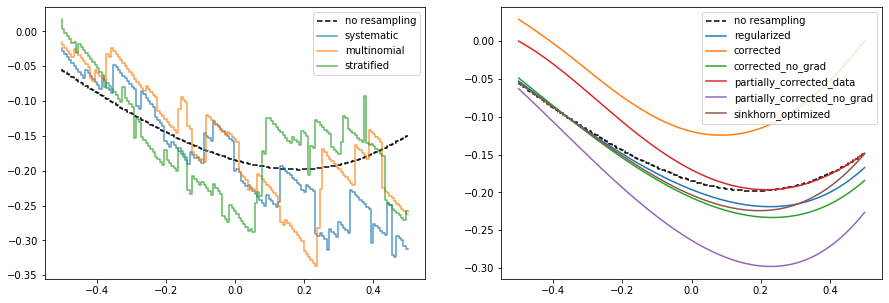

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=False)
axes[0].step(linspace, no_resampling_grad, label='no resampling', linestyle='--', color='k')
axes[1].step(linspace, no_resampling_grad, label='no resampling', linestyle='--', color='k')
axes[0].step(linspace, systematic_grad, label='systematic', alpha=0.75)
axes[0].step(linspace, multinomial_grad, label='multinomial', alpha=0.75)
axes[0].step(linspace, stratified_grad, label='stratified', alpha=0.75)
axes[1].plot(linspace, regularized_grad, label='regularized')
axes[1].plot(linspace, corrected_grad, label='corrected')
axes[1].plot(linspace, corrected_no_grad_grad, label='corrected_no_grad')
axes[1].plot(linspace, partially_corrected_grad, label='partially_corrected_data')
axes[1].plot(linspace, partially_corrected_no_grad_grad, label='partially_corrected_no_grad')
# axes[1].plot(linspace, sliced_optimized_data, label='sliced_optimized')
axes[1].plot(linspace, sinkhorn_optimized_grad, label='sinkhorn_optimized')
_ = axes[0].legend(), axes[1].legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration_gradient.png'))

In [12]:
partially_corrected_no_grad_grad

<tf.Tensor: shape=(150,), dtype=float32, numpy=
array([-0.06293778, -0.06584179, -0.06875291, -0.07167112, -0.07459638,
       -0.07752885, -0.08047079, -0.08341669, -0.08636889, -0.08933016,
       -0.0922942 , -0.09526357, -0.09824116, -0.10121981, -0.10420579,
       -0.10719159, -0.11018374, -0.11317433, -0.11617008, -0.11916292,
       -0.12215946, -0.12515552, -0.12814602, -0.13113834, -0.1341277 ,
       -0.1371132 , -0.14008982, -0.14306514, -0.14603421, -0.14899614,
       -0.15195014, -0.1548954 , -0.15783119, -0.16075632, -0.16367021,
       -0.16656712, -0.16945605, -0.17233145, -0.17519225, -0.17803793,
       -0.18086784, -0.18367538, -0.1864661 , -0.18923923, -0.19199397,
       -0.19472976, -0.19744572, -0.20014113, -0.20281528, -0.20546755,
       -0.2080971 , -0.21070343, -0.21328558, -0.21584305, -0.21837513,
       -0.22088753, -0.22337073, -0.22582676, -0.22825468, -0.23065048,
       -0.23302004, -0.23535597, -0.23766094, -0.23993805, -0.24217927,
       -0.244387